In [1]:
import cv2
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from pathlib import Path
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Input, Dense, Add, Conv2D, SeparableConv2D
from tensorflow.keras.layers import BatchNormalization, AveragePooling2D
from tensorflow.keras.layers import LeakyReLU, MaxPooling2D, Flatten
from tensorflow.keras.models import Model
import tensorflow as tf
from tensorflow.keras import backend as K

In [2]:
IMG_HEIGHT = 224
IMG_WIDTH = 224
X_FACTOR = IMG_WIDTH / 600 # 600 is dataset images shape
Y_FACTOR = IMG_HEIGHT / 600
BATCH_SIZE = 128
EPOCHS = 35
learning_rate = 0.0032
dataset_path = '../input/hand-detection-dataset-factory/hands'

In [3]:
def grabPaths(filepath):
    labels = [str(filepath[i]).split("/")[-1] \
              for i in range(len(filepath))]
    filepath = pd.Series(filepath, name='path').astype(str)
    df = pd.DataFrame(filepath)    
    return df

def rescale_boxes(boxes):
    # Rescale boxes (since we resscaled images sizes)
    boxes = np.array(boxes).astype(np.float32)
    boxes[:,[0,2]] = boxes[:,[0,2]] * X_FACTOR
    boxes[:,[1,3]] = boxes[:,[1,3]] * Y_FACTOR
    return boxes

def inverse_rescale_boxes(boxes):
    # Inverse scale of box coordinates
    # You should inverse scale based on the image
    boxes[:,[0,2]] = boxes[:,[0,2]] / X_FACTOR
    boxes[:,[1,3]] = boxes[:,[1,3]] / Y_FACTOR
    return boxes


def plot_bbox(image, yt_box, yp_box=None, norm=False):
    # Given an image and box coordinates, draw the box on the image
    if norm:
        image = image * 255.
        image = image.astype("uint8")
    
    try:
        pil_img = Image.fromarray(image)
    except:
        pil_img = Image.fromarray(image.astype('uint8'))
        
    draw_img = ImageDraw.Draw(pil_img)
    
    x1, y1, w, h = yt_box
    x2, y2 = x1+w, y1+h
    draw_img.rectangle((x1, y1, x2, y2), outline='green')
    
    if yp_box is not None:
        x1, y1, w, h = yp_box
        x2, y2 = x1+w, y1+h
        draw_img.rectangle((x1, y1, x2, y2), outline='red')
    return pil_img


def convblock(previous_layer, n_filters, filter_windows=(3,3,3), padding='same', pool=None):
    # [DepthwiseConv -> BatchNorm -> LeakyReLU] x3 + Residual connection -> Pooling (optional)

    x = SeparableConv2D(n_filters[0], filter_windows[0], padding=padding)(previous_layer)
    x_short = x
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = SeparableConv2D(n_filters[1], filter_windows[1], padding=padding)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = SeparableConv2D(n_filters[2], filter_windows[2], padding=padding)(x)
    x = BatchNormalization()(x)
    x = Add()([x, x_short])
    x = LeakyReLU()(x)
    
    if pool == 'max':
        x = MaxPooling2D(pool_size=(2,2))(x)
    elif pool == 'avg':
        x = AveragePooling2D(pool_size=(2,2))(x)
    
    return x


# Function to calculate MSE Loss function
# for samples where object exists
def custom_mse(y_true, y_pred):
    mask = K.not_equal(K.sum(y_true, axis=1), 0.0)
    y_true_custom = y_true[mask]
    y_pred_custom = y_pred[mask]
    mse = tf.keras.losses.MeanSquaredError()
    result = mse(y_true_custom, y_pred_custom) # * 0.3
    return result


# Function to preview samples of the dataset
def visualize_samples(datagen, row_col_len=4, figsize=None):
    figsize = figsize or np.array((row_col_len, row_col_len)) * 4
    fig, ax = plt.subplots(row_col_len, row_col_len, figsize=figsize)
    for i in range(row_col_len):
        for j in range(row_col_len):
            batch_index = np.random.randint(0, BATCH_SIZE/2)
            output_classes = np.array(datagen[batch_index][1]['class_out'])
            classes_true = np.where(output_classes == 1)[0]
            sample_index = classes_true[np.random.randint(0, classes_true.shape[0])]
            image = datagen[batch_index][0][sample_index]
            box = datagen[batch_index][1]['box_out'][sample_index]
            plotted_box = plot_bbox(image, box, norm=True)
            ax[i,j].imshow(plotted_box)
            ax[i,j].set_axis_off()
    plt.show()
    

# Function to make a prediction during training
def visualize_prediction(model, data):    
    # Select a sample where an object exists
    output_classes = np.array(data[0][1]['class_out'])
    sample_index = np.where(output_classes == 1)[0]
    sample_index = sample_index[0] if sample_index[0] else 0 
    
    # Get image
    image = np.array([data[0][0][sample_index]])
    
    # Set y_true & y_pred for class & bounding box
    yt_box = np.array([data[0][1]['box_out'][sample_index]])
    yt_class = np.array([data[0][1]['class_out'][sample_index]])
    yp_class, yp_box = model.predict(image)

    # Plot bounding box on image & show it
    image_plotted = plot_bbox(image[0], yt_box[0], yp_box[0], norm=True) 
    plt.imshow(image_plotted)
    plt.axis('off')
    
    # Print y_true class & y_pred class
    print("Class: y_true=", yt_class, " | y_pred=", int(yp_class >= 0.5))
    plt.show()

In [4]:
# Read CSV
dataset = pd.read_csv('../input/arabic-sign-language-dataset-1/dataset.csv')

# REMOVE THE LINE BELOW TO USE ALL SAMPLES
# dataset = dataset.sample(n=15000)

dataset.columns = ['path', 'object_exists', 'x', 'y', 'w', 'h']


# # Create dataframe of {paths, labels}
dataset['path'] = "../input/arabic-sign-language-dataset-1/arabic-sign-lang/" + dataset['path']

# Resize boxes
dataset.iloc[:,2:] = rescale_boxes(dataset.iloc[:,2:])

In [5]:
# Read CSV
dataset2 = pd.read_csv('../input/arabic-sign-language-dataset-2/dataset.csv')

# REMOVE THE LINE BELOW TO USE ALL SAMPLES
# dataset = dataset.sample(n=15000)

dataset2.columns = ['path', 'object_exists', 'x', 'y', 'w', 'h']


# # Create dataframe of {paths, labels}
dataset2['path'] = "../input/arabic-sign-language-dataset-2/arabic-sign-lang/" + dataset2['path']

# Resize boxes
dataset2.iloc[:,2:] = rescale_boxes(dataset2.iloc[:,2:])

dataset = pd.concat((dataset, dataset2))

In [ ]:
dataset['object_exists'].unique()

In [6]:
train_df, test_df = train_test_split(dataset, test_size=0.05)

In [7]:
def get_image(path):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image
    
def visualize_samples(datagen, row_col_len=4, figsize=None):
    random_indexes = np.random.randint(0, len(datagen.labels), row_col_len**2)
    
    classes = np.array(list(datagen.class_indices))
    labels = classes[np.array(datagen.labels)[random_indexes]]
    filepaths = pd.Series(datagen.filenames)[random_indexes]
    images = filepaths.apply(get_image).reset_index(drop=True)
    
    figsize = figsize or np.array((row_col_len, row_col_len)) * 4
    fig, ax = plt.subplots(row_col_len, row_col_len, figsize=figsize)
    for i in range(row_col_len):
        for j in range(row_col_len):
            sample_index = i * row_col_len + j
            ax[i,j].imshow(images[sample_index])
            ax[i,j].set_title(labels[sample_index])
            ax[i,j].set_axis_off()
    plt.show()

In [17]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    brightness_range=(0.8, 1.2),
    horizontal_flip=True,
    rescale = 1./255.,
#      preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255.,
#      preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
)

train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='path',
    y_col='object_exists',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='path',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    color_mode='rgb',
    y_col='object_exists',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
)


# custom_train_gen = MultiOutputGen(train_images, train_df.iloc[:,1:])
# custom_test_gen = MultiOutputGen(test_images, test_df.iloc[:,1:])

Found 56829 validated image filenames belonging to 34 classes.
Found 2991 validated image filenames belonging to 34 classes.


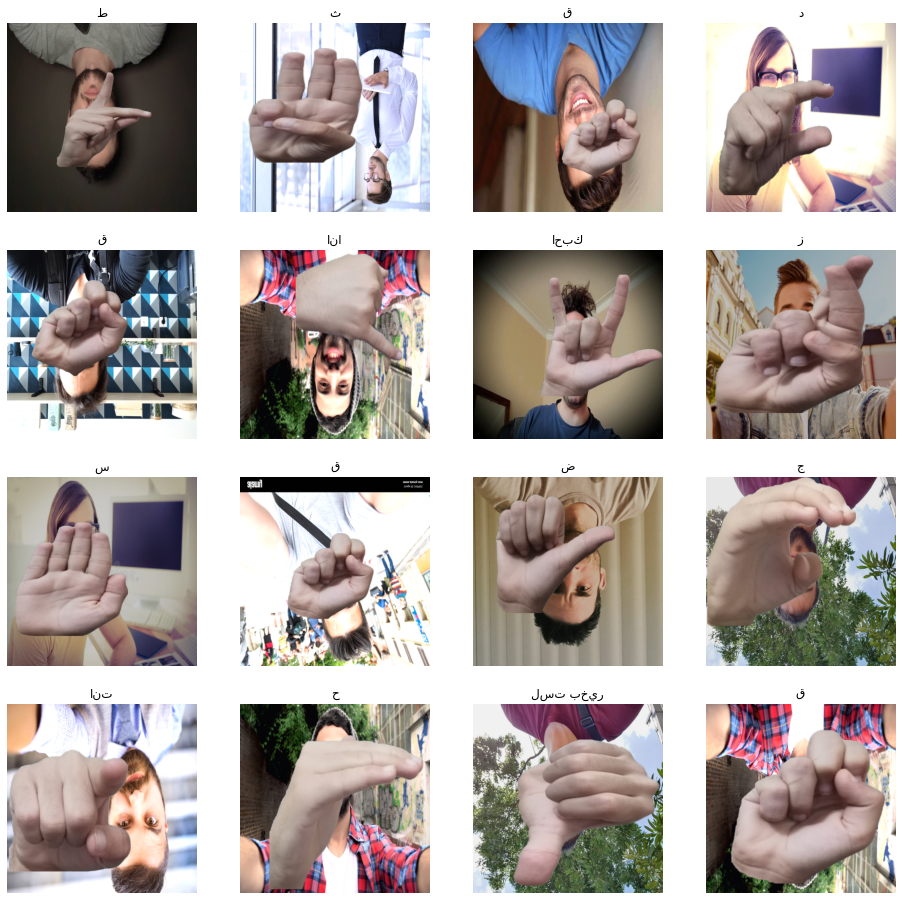

In [18]:
visualize_samples(train_images)

In [19]:
pretrainedModel = tf.keras.applications.ResNet50V2(
    input_shape=(224, 224, 3),
     include_top=False,
     weights='imagenet',
     pooling='avg'
)
pretrainedModel.trainable = False

inputs = pretrainedModel.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrainedModel.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(34, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

# adam = tf.keras.optimizers.Adam(learning_rate = 0.005)


2022-05-21 18:29:49.976644: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-21 18:29:50.081184: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-21 18:29:50.082013: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-21 18:29:50.083473: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

94683136/94668760 [==============================] - 8s 0us/step


In [20]:
save_best_model = tf.keras.callbacks.ModelCheckpoint(
    filepath='./best_hand_detection.h5',
    monitor='val_loss',
    mode='min',
    save_best_only=True)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=tf.math.exp(-0.1),
    patience=1,
    verbose=1,
    mode="min",
    min_lr=0.0004,
)
optimizer_adam = tf.keras.optimizers.Adam(learning_rate = 0.005)

model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizer_adam,
    metrics='accuracy'
)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
______________________________________________________________________________________________

In [21]:
history = model.fit(
    train_images,
    epochs=4,
    validation_data=test_images,
    callbacks=[
        reduce_lr,
        save_best_model
    ]
)

2022-05-21 18:30:09.082086: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/4


2022-05-21 18:30:15.523839: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


444/444 [==============================] - 1202s 3s/step - loss: 0.9208 - accuracy: 0.7054 - val_loss: 0.4848 - val_accuracy: 0.8348


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/4
444/444 [==============================] - 1163s 3s/step - loss: 0.4081 - accuracy: 0.8598 - val_loss: 0.3006 - val_accuracy: 0.9034
Epoch 3/4
444/444 [==============================] - 1212s 3s/step - loss: 0.3472 - accuracy: 0.8809 - val_loss: 0.2938 - val_accuracy: 0.8987
Epoch 4/4
444/444 [==============================] - 1209s 3s/step - loss: 0.3008 - accuracy: 0.8954 - val_loss: 0.2697 - val_accuracy: 0.9101


In [1]:
# Save model for later use

# for python apps (& APIs)
model.save("Arabic Sign Lang Recognition.h5")

# for mobile apps & microcontrollers (TensorFlow Lite)
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open("Arabic Sign Lang Recognition.tflite", 'wb') as file:
    file.write(tflite_model)

NameError: name 'model' is not defined